# Hawaii climate analysis

## Initial setup

### Import dependencies

In [1]:
# %matplotlib inline
from matplotlib import style
style.use('bmh')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


In [3]:
# Python SQL toolkit and Object Relational Mapper
# import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc


### Define functions

In [4]:
def inspect_columns(engine, table_name):
    columns = inspect(engine).get_columns(table_name)
    print('Name', 'Type', sep=(' ' * 12)+'| ')
    print('-' * 16, '-' * 8, sep='|')
    for c in columns:
        print(f"{c['name']:16}| {c['type']}")


## Connect to the database of Climate Data

### Reflect Tables into SQLAlchemy ORM

In [5]:
# Create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [6]:
# Reflect an existing database into a new model
Base = automap_base()


# Reflect the tables
Base.prepare(autoload_with=engine)


In [7]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


### Create session

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


### Inspect columns

In [10]:
# Inspect column names and types of measurement table
inspect_columns(engine, 'measurement')


Name            | Type
----------------|--------
id              | INTEGER
station         | TEXT
date            | TEXT
prcp            | FLOAT
tobs            | FLOAT


In [11]:
# Inspect column names and types of station table
inspect_columns(engine, 'station')


Name            | Type
----------------|--------
id              | INTEGER
station         | TEXT
name            | TEXT
latitude        | FLOAT
longitude       | FLOAT
elevation       | FLOAT


## Exploratory Analysis 

### Precipitation Analysis

In [12]:
# Check formatting of date string by getting first 15 date values
session.query(Measurement.date).limit(15).all()


[('2010-01-01',),
 ('2010-01-02',),
 ('2010-01-03',),
 ('2010-01-04',),
 ('2010-01-06',),
 ('2010-01-07',),
 ('2010-01-08',),
 ('2010-01-09',),
 ('2010-01-10',),
 ('2010-01-11',),
 ('2010-01-12',),
 ('2010-01-14',),
 ('2010-01-15',),
 ('2010-01-16',),
 ('2010-01-17',)]

In [13]:
# Find the most recent date in the data set.
# Because we saw in the previous cell that the year is first, then month, we can use func.max to find the biggest date
most_recent_date = session.query(func.max(Measurement.date)).all()
most_recent_date


[('2017-08-23',)]

In [14]:
# Convert most recent date to a date object
most_recent_date = pd.to_datetime(most_recent_date[0][0]).date()
most_recent_date


datetime.date(2017, 8, 23)

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Reduce most recent date by 1 year and store in lower_limit_date
# documentation on date.replace():
# https://docs.python.org/3/library/datetime.html#datetime.date.replace
lower_limit_date = most_recent_date.replace(year=most_recent_date.year - 1)
lower_limit_date


datetime.date(2016, 8, 23)

In [16]:
# Perform a query to retrieve the date and precipitation scores
date_and_precipitation = (session
    .query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date >= lower_limit_date)
    .all()
)
print(f"Number of rows returned: {len(date_and_precipitation)}\n\nFirst 25 rows:")
date_and_precipitation[0:24]


Number of rows returned: 2230

First 25 rows:


[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42)]

In [17]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(date_and_precipitation, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df = (precipitation_df
    .sort_values('Date')
    .dropna()
    .reset_index(drop=True)
)

# Convert Date column to date type
# https://saturncloud.io/blog/converting-object-column-in-pandas-dataframe-to-datetime-a-data-scientists-guide/
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'])

precipitation_df.head(10)


,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-23,1.79
2,2016-08-23,0.05
3,2016-08-23,0.15
4,2016-08-23,0.70
5,2016-08-23,0.02
6,2016-08-24,0.08
7,2016-08-24,2.15
8,2016-08-24,2.28
9,2016-08-24,1.45


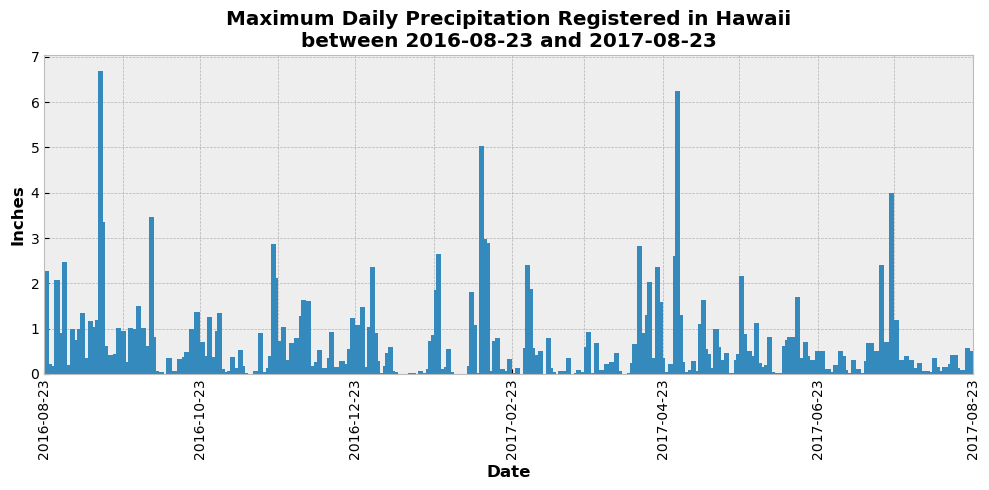

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(10, 5))

# Find max precipitation per date
df = (precipitation_df
    .groupby('Date', as_index=False)
    .max()
)

# Plot date and max precipitation
ax.bar(df['Date'], df['Precipitation'], width=2)
# Set x limits to desired dates
ax.set_xlim((lower_limit_date, most_recent_date))
# Rotate x ticks
plt.xticks(df['Date'], rotation=90)

# Set x axis format based on dates
# https://matplotlib.org/stable/api/dates_api.html#matplotlib.dates.MonthLocator
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=23, interval=2))
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=23))
# https://stackoverflow.com/a/64920221
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Format x and y labels and title
bold_font = {'weight': 700}
ax.set_xlabel('Date', fontdict=bold_font)
ax.set_ylabel('Inches', fontdict=bold_font)
ax.set_title(
    f'Maximum Daily Precipitation Registered in Hawaii\nbetween {lower_limit_date} and {most_recent_date}',
    fontdict=bold_font
)

# Add grid behind
ax.grid(True, 'both', 'x')
ax.set_axisbelow(True)

fig.tight_layout()
plt.show()


In [19]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = precipitation_df.describe()
precipitation_summary


,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [20]:
# Design a query to calculate the total number of stations in the dataset
number_of_stations = session.query(Station.station).distinct().count()
number_of_stations


9

In [21]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
# how to label agg columns: 
# https://www.geeksforgeeks.org/sqlalchemy-label/
# how to sort using agg labeled columns: 
# https://docs.sqlalchemy.org/en/14/tutorial/data_select.html#tutorial-group-by-w-aggregates
station_activity = (session
    .query(
        Station.station,
        func.count(Measurement.id).label('count')
    )
    .filter(Measurement.station == Station.station)
    .group_by(Station.station)
    .order_by(desc('count'))
    .all()
)
station_activity


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Get the most active station
most_active_station = station_activity[0][0]

# Get min, max and average tobs for most_active_station
most_active_station_summary = (session
    .query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)
    )
    .filter(Measurement.station == most_active_station)
    .group_by(Measurement.station)
    .all()
)
most_active_station_summary


[(54.0, 85.0, 71.66378066378067)]

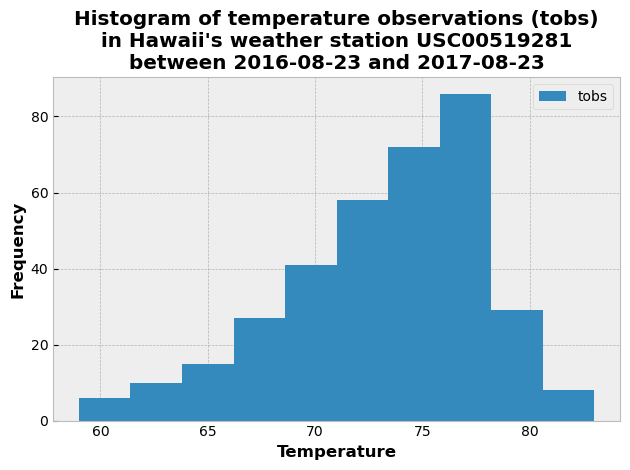

In [23]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_tobs = (session
                .query(Measurement.tobs)
                .filter(Measurement.date >= lower_limit_date)
                .filter(Measurement.station == most_active_station)
                .all()
                )

# Generate histogram
fig, ax = plt.subplots()
pd.DataFrame(most_active_station_tobs).plot.hist(ax=ax)
# Add and format title, x and y labels
ax.set_xlabel('Temperature', fontdict=bold_font)
ax.set_ylabel('Frequency', fontdict=bold_font)
ax.set_title(
    f"Histogram of temperature observations (tobs)\n" +
    f"in Hawaii's weather station {most_active_station}\n" +
    f"between {lower_limit_date} and {most_recent_date}",
    fontdict=bold_font
)

# Add grid behind
ax.grid(True)
ax.set_axisbelow(True)

fig.tight_layout()
plt.show()


## Close Session

In [24]:
# Close Session
session.close()
